# DCGAN

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Layer, Conv2D, BatchNormalization, Flatten, Conv2DTranspose

## Generator

In [2]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = Dense(7*7*512, use_bias=False, input_shape=(100,))
        self.bn = BatchNormalization()
        self.lrelu = LeakyReLU()
        
        self.deconv1 = Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False)
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.deconv2 = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.deconv3 = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')
        
    def call(self, x, training=None, mask=None):
        h = self.lrelu(self.bn(self.dense(x), training))
        h = tf.reshape(h, (-1, 7, 7, 512))
        h = self.lrelu1(self.bn1(self.deconv1(h), training))
        h = self.lrelu2(self.bn2(self.deconv2(h), training))
        return self.deconv3(h)

## Discriminator

In [3]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(64, (5, 5), strides= (2, 2), padding='same')
        self.bn1 = BatchNormalization()
        self.lrelu1 = LeakyReLU()
        
        self.conv2 = Conv2D(128, (5, 5), strides=(2, 2), padding='same')
        self.bn2 = BatchNormalization()
        self.lrelu2 = LeakyReLU()
        
        self.flatten = Flatten()
        self.dense = Dense(1, activation='sigmoid')
        

    def call(self, x, training=None, mask=None):
        h = self.lrelu1(self.bn1(self.conv1(x), training))
        h = self.lrelu2(self.bn2(self.conv2(h), training))
        return self.dense(h)

## Datasets

In [5]:
dataset = tfds.load(name='fashion_mnist', split=tfds.Split.TRAIN)
dataset = dataset.map(lambda x: tf.cast(x['image'], tf.float32) / 255.0).batch(32)

Shuffling and writing examples to C:\/Users/User/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOCPKL6/fashion_mnist-train.tfrecord


Shuffling and writing examples to C:\/Users/User/tensorflow_datasets/fashion_mnist/3.0.1.incompleteOCPKL6/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to C:\Users\User\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


## Model, Optimizers

In [6]:
generator = Generator()
discriminator = Discriminator()

optim_d = tf.optimizers.Adam(1e-4)
optim_g = tf.optimizers.Adam(1e-4)

d_mean = tf.metrics.Mean()
g_mean = tf.metrics.Mean()

## Losses

In [7]:
def discriminator_loss(d_real, d_fake):
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_real), d_real)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(d_fake), d_fake)
    return real_loss + fake_loss

def generator_loss(d_fake):
    return tf.keras.losses.BinaryCrossentropy()(tf.ones_like(d_fake), d_fake)

## Training Step

In [8]:
@tf.function
def train_step(image, optim_d, optim_g):
    with tf.GradientTape() as tape_d, tf.GradientTape() as tape_g:
        z = tf.random.normal([32, 100])
        g = generator(z, training=True)
        
        d_real = discriminator(image, training=True)
        d_fake = discriminator(g, training=True)
        
        d_loss = discriminator_loss(d_real, d_fake)
        g_loss = generator_loss(d_fake)
        
        gradients_d = tape_d.gradient(d_loss, discriminator.trainable_weights)
        gradients_g = tape_g.gradient(g_loss, generator.trainable_weights)
    
    optim_d.apply_gradients(zip(gradients_d, discriminator.trainable_weights))
    optim_g.apply_gradients(zip(gradients_g, generator.trainable_weights))
    return d_loss, g_loss

## Training Loop

epoch: 1, d_loss: 1.007657527923584, g_loss: 0.9369602203369141


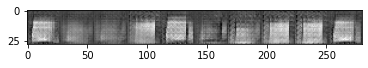

epoch: 2, d_loss: 1.1434659957885742, g_loss: 0.8695822954177856
epoch: 3, d_loss: 1.1365022659301758, g_loss: 0.8835750222206116
epoch: 4, d_loss: 1.1234824657440186, g_loss: 0.9041964411735535
epoch: 5, d_loss: 1.102754831314087, g_loss: 0.9283785820007324
epoch: 6, d_loss: 1.1071583032608032, g_loss: 0.9333938956260681
epoch: 7, d_loss: 1.0992456674575806, g_loss: 0.9468539953231812
epoch: 8, d_loss: 1.068687915802002, g_loss: 0.9773521423339844
epoch: 9, d_loss: 1.0655388832092285, g_loss: 0.9912747144699097
epoch: 10, d_loss: 1.055659532546997, g_loss: 1.0028706789016724
epoch: 11, d_loss: 1.0715523958206177, g_loss: 0.9981642365455627


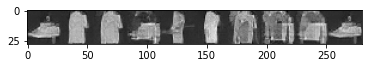

epoch: 12, d_loss: 1.054344654083252, g_loss: 1.0209150314331055
epoch: 13, d_loss: 1.0559970140457153, g_loss: 1.0243196487426758
epoch: 14, d_loss: 1.0553905963897705, g_loss: 1.031051754951477
epoch: 15, d_loss: 1.0307551622390747, g_loss: 1.054945945739746
epoch: 16, d_loss: 1.03075110912323, g_loss: 1.0618778467178345
epoch: 17, d_loss: 1.0096726417541504, g_loss: 1.088326334953308
epoch: 18, d_loss: 1.0163164138793945, g_loss: 1.0892298221588135
epoch: 19, d_loss: 1.009203314781189, g_loss: 1.098925232887268
epoch: 20, d_loss: 1.0253973007202148, g_loss: 1.0909918546676636
epoch: 21, d_loss: 1.029341459274292, g_loss: 1.0891274213790894


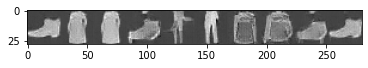

epoch: 22, d_loss: 1.012935757637024, g_loss: 1.106266975402832
epoch: 23, d_loss: 1.0040313005447388, g_loss: 1.121450662612915
epoch: 24, d_loss: 1.018179178237915, g_loss: 1.1143826246261597
epoch: 25, d_loss: 1.025045394897461, g_loss: 1.1067206859588623
epoch: 26, d_loss: 1.023549199104309, g_loss: 1.1123288869857788
epoch: 27, d_loss: 1.0192097425460815, g_loss: 1.1196298599243164
epoch: 28, d_loss: 1.0105764865875244, g_loss: 1.1280351877212524
epoch: 29, d_loss: 1.0148541927337646, g_loss: 1.1306577920913696
epoch: 30, d_loss: 1.0273886919021606, g_loss: 1.116339087486267
epoch: 31, d_loss: 1.0312209129333496, g_loss: 1.12138831615448


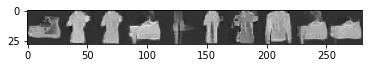

epoch: 32, d_loss: 1.0117511749267578, g_loss: 1.1412684917449951
epoch: 33, d_loss: 1.0271707773208618, g_loss: 1.1272534132003784
epoch: 34, d_loss: 1.0392471551895142, g_loss: 1.1176135540008545
epoch: 35, d_loss: 1.0173125267028809, g_loss: 1.1429907083511353
epoch: 36, d_loss: 1.0335510969161987, g_loss: 1.129936933517456
epoch: 37, d_loss: 1.0328521728515625, g_loss: 1.1331804990768433
epoch: 38, d_loss: 1.025409460067749, g_loss: 1.1399000883102417
epoch: 39, d_loss: 0.9961727857589722, g_loss: 1.171268105506897
epoch: 40, d_loss: 1.0270792245864868, g_loss: 1.143928050994873
epoch: 41, d_loss: 1.014744520187378, g_loss: 1.1565141677856445


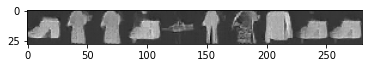

epoch: 42, d_loss: 1.0398935079574585, g_loss: 1.1416032314300537
epoch: 43, d_loss: 1.009777307510376, g_loss: 1.1651403903961182
epoch: 44, d_loss: 1.007949709892273, g_loss: 1.163651943206787
epoch: 45, d_loss: 1.0139261484146118, g_loss: 1.1621745824813843
epoch: 46, d_loss: 1.033410906791687, g_loss: 1.1503247022628784


KeyboardInterrupt: 

In [9]:
sample_z = tf.random.normal([10, 100])
for epoch in range(100):
    for image in dataset:
        d_loss, g_loss = train_step(image, optim_d, optim_g)

        d_mean.update_state(d_loss)
        g_mean.update_state(g_loss)

    print('epoch: {}, d_loss: {}, g_loss: {}'.format(epoch+1, d_mean.result(), g_mean.result()))
    
    if epoch % 10 == 0:
        img_list = list()
        sample_img = generator(sample_z)
        for idx in range(sample_img.shape[0]):
            img_list.append(sample_img[idx][:, :, 0])
        img = np.concatenate(img_list, axis=1)
        plt.imshow(img, cmap='gray')
        plt.show()

    d_mean.reset_states()
    g_mean.reset_states()